In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder,TorchNormalizer
#from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import MAPE, MAE, MASE
from pytorch_forecasting.metrics import NormalDistributionLoss

## Data Loading

In [3]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
#train = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [4]:
main_df = pd.read_csv('M5_main_df.csv', parse_dates=['date'])

In [5]:
main_df.head()

,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
0,2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,...,23178,3764,5689,2343,4094,16741,3610,154,4105,1584
1,2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,...,22758,3357,5634,2216,4209,16333,3172,185,3858,1776
2,2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,...,17174,2682,3927,1657,3174,12343,2497,185,2827,1100
3,2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,...,18878,2669,3865,1508,3606,13764,2531,138,2732,1133
4,2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,...,14603,1814,2729,1209,2869,10525,1714,100,1802,927


In [6]:
for col in main_df.columns[1:]:
    main_df.loc[:, col] = main_df.loc[:, col].astype(float)

## Data Splitting

In [8]:
train_size = 0.8

train_df = main_df.iloc[:int(len(main_df)*train_size)]
test_df = main_df.iloc[int(len(main_df)*train_size):]

## Time Series Data Formatting
PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the documentation, a combination of group_id and time_idx identify a sample in the data, and that if we have only one time series, to set group_id to a constant.

time_idx is an integer column denoting the time index. This, as opposed to the date column, is used to determine the temporal sequence of samples.

In [9]:
lag_time = 30
lead_time = 30

train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)
#why we need two reset_index()

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [10]:
test_df

,time_idx,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,...,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,group_ids
0,1552,2015-04-30,30553.0,12985.0,8967.0,8601.0,3466.0,2045.0,5114.0,2360.0,...,3318.0,7181.0,2577.0,3406.0,14071.0,2998.0,320.0,5555.0,1626.0,0
1,1553,2015-05-01,40976.0,17168.0,12238.0,11570.0,5121.0,2773.0,6637.0,2637.0,...,4314.0,10470.0,3468.0,4380.0,18344.0,3921.0,393.0,8414.0,2056.0,0
2,1554,2015-05-02,47052.0,19497.0,13252.0,14303.0,5801.0,3068.0,7586.0,3042.0,...,4312.0,11325.0,3425.0,5353.0,22637.0,3919.0,393.0,9097.0,2228.0,0
3,1555,2015-05-03,49102.0,20394.0,13859.0,14849.0,6524.0,3347.0,7757.0,2766.0,...,4315.0,11777.0,3437.0,6377.0,23196.0,3926.0,389.0,9424.0,2353.0,0
4,1556,2015-05-04,38169.0,17031.0,10376.0,10762.0,4794.0,2094.0,7345.0,2798.0,...,3927.0,9471.0,2692.0,5108.0,16971.0,3527.0,400.0,7569.0,1902.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,1936,2016-05-18,37096.0,15678.0,10375.0,11043.0,3995.0,3789.0,5375.0,2519.0,...,3740.0,8566.0,3073.0,4648.0,17069.0,3291.0,449.0,6641.0,1925.0,0
385,1937,2016-05-19,36963.0,16297.0,9162.0,11504.0,4136.0,4037.0,5580.0,2544.0,...,3475.0,8751.0,3251.0,4551.0,16935.0,3027.0,448.0,6759.0,1992.0,0
386,1938,2016-05-20,42552.0,17430.0,12303.0,12819.0,4433.0,4751.0,5542.0,2704.0,...,4143.0,10273.0,3735.0,4815.0,19586.0,3761.0,382.0,7974.0,2299.0,0
387,1939,2016-05-21,51518.0,23103.0,13681.0,14734.0,5764.0,7120.0,7073.0,3146.0,...,5333.0,12586.0,4195.0,5940.0,23464.0,4832.0,501.0,9668.0,2918.0,0


In [11]:
train_df

,time_idx,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,...,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,group_ids
0,0,2011-01-29,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,...,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,0
1,1,2011-01-30,31749.0,13805.0,9630.0,8314.0,4155.0,3046.0,4827.0,1777.0,...,3357.0,5634.0,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0,0
2,2,2011-01-31,23783.0,10108.0,6778.0,6897.0,2816.0,2121.0,3785.0,1386.0,...,2682.0,3927.0,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0,0
3,3,2011-02-01,25412.0,11047.0,7381.0,6984.0,3051.0,2324.0,4232.0,1440.0,...,2669.0,3865.0,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0,0
4,4,2011-02-02,19146.0,9925.0,5912.0,3309.0,2630.0,1942.0,3817.0,1536.0,...,1814.0,2729.0,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,1547,2015-04-25,43598.0,19071.0,12049.0,12478.0,6019.0,3230.0,7251.0,2571.0,...,4519.0,11531.0,3272.0,4967.0,19309.0,3991.0,528.0,9152.0,2379.0,0
1548,1548,2015-04-26,43406.0,19426.0,12387.0,11593.0,5815.0,2947.0,7890.0,2774.0,...,4463.0,10800.0,3220.0,4987.0,19936.0,3980.0,483.0,8480.0,2320.0,0
1549,1549,2015-04-27,33444.0,14773.0,9873.0,8798.0,3995.0,2257.0,5909.0,2612.0,...,3412.0,7923.0,2683.0,4303.0,15123.0,3045.0,367.0,6253.0,1670.0,0
1550,1550,2015-04-28,29750.0,13044.0,8805.0,7901.0,3526.0,1930.0,5420.0,2168.0,...,3098.0,7276.0,2474.0,3608.0,13294.0,2792.0,306.0,5678.0,1598.0,0


## Preparing a TimeSeriesDataSet for N-BEATS
N-BEATS is a univariate forecasting method. As such, it can only process one variable at a time.

In [12]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=main_df.columns, var_name='group_ids')
train_df_nbeats.head()

,time_idx,date,group_ids,value
0,0,2011-01-29,all,32631.0
1,1,2011-01-30,all,31749.0
2,2,2011-01-31,all,23783.0
3,3,2011-02-01,all,25412.0
4,4,2011-02-02,all,19146.0


In [13]:
train_df_nbeats.tail()

,time_idx,date,group_ids,value
37243,1547,2015-04-25,HOUSEHOLD_2,2379.0
37244,1548,2015-04-26,HOUSEHOLD_2,2320.0
37245,1549,2015-04-27,HOUSEHOLD_2,1670.0
37246,1550,2015-04-28,HOUSEHOLD_2,1598.0
37247,1551,2015-04-29,HOUSEHOLD_2,1556.0


In [14]:
train_df_nbeats.dtypes

time_idx              int64
date         datetime64[ns]
group_ids            object
value               float64
dtype: object

In [15]:
train_df_nbeats.group_ids.unique()

array(['all', 'CA', 'TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1',
       'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'FOODS', 'HOBBIES',
       'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1',
       'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2'], dtype=object)

In [16]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

In [17]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [18]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
# !!!!! dont use int as target EVER !!!!

In [19]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=1)
#increase num_workers here

In [21]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
#Try verbose=True

trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    #some other functions?
    limit_train_batches=1.0,
    default_root_dir='/ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL'
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [22]:
net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  coefficients = torch.tensor([backcast_linspace ** i for i in range(thetas_dim)], dtype=torch.float32)


In [23]:
%%time
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.717     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Metric val_loss improved. New best score: 0.844


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.114 >= min_delta = 0.0001. New best score: 0.730


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.699


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.694


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.691


CPU times: user 10min 47s, sys: 5min 16s, total: 16min 3s
Wall time: 10min 9s


In [34]:
print(trainer.checkpoint_callback.best_model_path)

/ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL/lightning_logs/version_6379813/checkpoints/epoch=9-step=2069.ckpt


In [35]:
!ls /ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL/lightning_logs/version_6379813/checkpoints

'epoch=9-step=2069.ckpt'


In [36]:
#prophet

In [24]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="all",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["all"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [25]:
#best_model_path = trainer.checkpoint_callback.best_model_path
#best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = net.predict(test_dataloader)

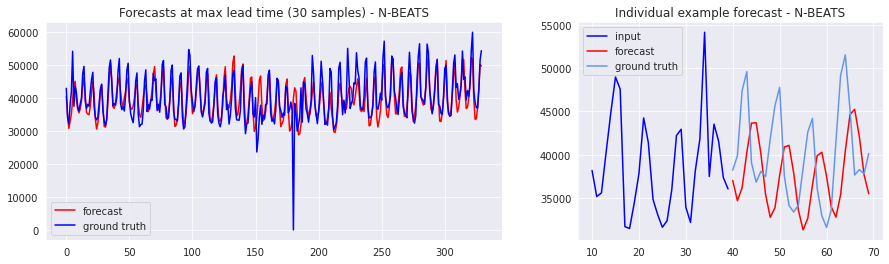

In [26]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()

In [30]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="HOUSEHOLD_2",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["HOUSEHOLD_2"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [31]:
#best_model_path = trainer.checkpoint_callback.best_model_path
#best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = net.predict(test_dataloader)

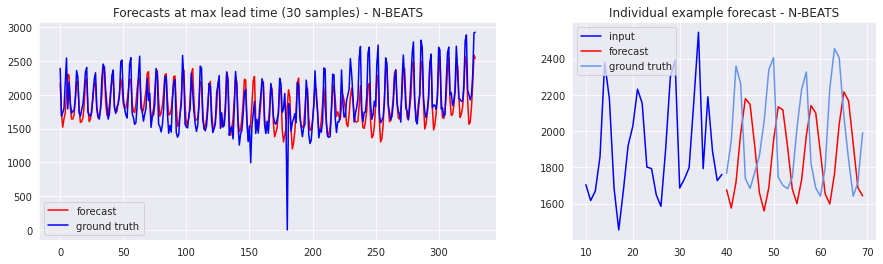

In [32]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()

In [201]:
net2 = NBeats.from_dataset(
    training,
    learning_rate=5e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

In [202]:
trainer.fit(
    net2,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.717     Total estimated model params size (MB)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/ligh

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [203]:
predictions2 = net2.predict(test_dataloader)

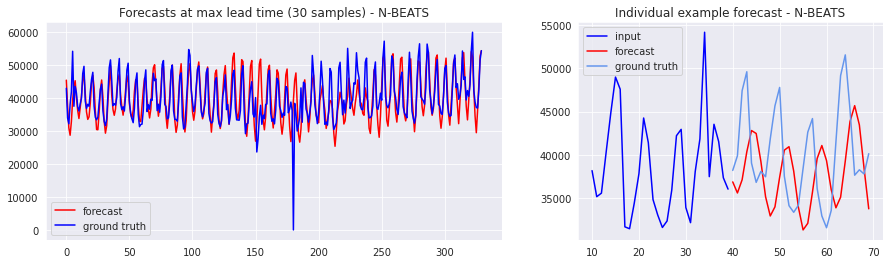

In [204]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions2.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()